# Projeto #1 - Classificação

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/classifier_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 1635078 | Coluna:  24


### Remove variáveis possíveis outliers
> Condutores com mais de 100 e menos de 10 anos

In [3]:
df['outlier'] = df.apply(lambda x: identifierConductorsOver100OrUnder10YearsOld(x.tipo_envolvido, x.idade), axis=1)
df.drop(df[df['outlier'] == 'outlier'].index, inplace=True)
df.drop(['outlier'], axis=1, inplace=True)

### Geração de features

Causa presumível do acidente com base nas características

In [4]:
df['causa_presumivel_acidente'] = df['causa_acidente'].apply(mapCausaAcidentes)

Define o horário do acidente

In [5]:
df['horario_acidente'] = df['horario'].apply(mapHorarioAcidentes)

Categorização do ano de fabricação do veículo com base na data do acidente

In [6]:
labels = ['ate dez anos', 'mais de dez anos']
classes = [0, 10, 170]

df['tempo_fabricacao_no_ano_do_acidente'] = df['ano'] - df['ano_fabricacao_veiculo']
df['faixa_ano_fabricacao'] = pd.cut(x=df['tempo_fabricacao_no_ano_do_acidente'], bins=classes, labels=labels, include_lowest=True)

Agrupamento tipo de envolvido

In [7]:
df['tipo_envolvido'] = df.apply(lambda x: mapTipoEnvolvido(x.tipo_veiculo, x.tipo_envolvido), axis=1)

Combinação das variáveis tipo de veículo e tipo de envolvido

> Identifica a forma como se deu a participação da vítima no acidente

In [8]:
df['condicao_envolvimento'] = df.apply(lambda x: mapCondicaoEnvolvimento(x.tipo_envolvido, x.tipo_veiculo), axis=1)
df.drop(df[df['condicao_envolvimento'] == 'outros'].index, inplace=True)

Agrupamento dos tipos de acidentes

In [9]:
df['tipo_acidente'] = df['tipo_acidente'].apply(mapTiposDeAcidentes)

Agrupamento traçado da via

In [10]:
df['tracado_via'] = df['tracado_via'].apply(mapTracadoVia)

Agrupamento idade

In [11]:
labels = ['criança', 'adolescente', 'jovem', 'adulto', 'idoso']
classes = [0, 11, 17, 29, 59, 99]
df['faixa_etaria'] = pd.cut(x=df['idade'], bins=classes, labels=labels, include_lowest=True)

### Agrupamento estado físico

In [12]:
df['estado_fisico'] = df['estado_fisico'].map({'morto': 'com mortos', 'ferido leve': 'sem mortos', 'ferido grave': 'sem mortos', 'ileso': 'sem mortos'})
print((df['estado_fisico'].value_counts(normalize=True)*100).round(1))

sem mortos    98.1
com mortos     1.9
Name: estado_fisico, dtype: float64


### Balanceamento da base

In [14]:
com_mortos = df.query('estado_fisico=="com mortos"')
sem_mortos = df.query('estado_fisico!="com mortos"').groupby('estado_fisico').apply(lambda x : x.sample(n=30352, replace=False))
sample = pd.concat([com_mortos, sem_mortos]).reset_index(drop=True)
sample['estado_fisico'].value_counts()

com mortos    30352
sem mortos    30352
Name: estado_fisico, dtype: int64

### Seleção de features

In [15]:
colunas = [
    'dia_semana',
    'uf',
    'br',
    'tipo_acidente',
    'sentido_via',
    'condicao_metereologica',
    'tipo_pista',
    'tracado_via',
    'uso_solo',
    'sexo',
    'causa_presumivel_acidente',
    'horario_acidente',
    'faixa_ano_fabricacao',
    'condicao_envolvimento',
    'faixa_etaria',
    'estado_fisico'
]

dados = sample[colunas]
print(f'Linhas: {dados.shape[0]} | Coluna:  {dados.shape[1]}')
dados.head(1)

Linhas: 60704 | Coluna:  16


,dia_semana,uf,br,tipo_acidente,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,sexo,causa_presumivel_acidente,horario_acidente,faixa_ano_fabricacao,condicao_envolvimento,faixa_etaria,estado_fisico
0,quarta,BA,242,saída da pista,decrescente,ceu claro,simples,curva,rural,feminino,outros aspectos não identificados,tarde,ate dez anos,ocupante de caminhonete/camioneta,adulto,com mortos


### Separação dos dados

In [16]:
X = dados.drop(['estado_fisico'], axis=1)
y = dados['estado_fisico']

### Label encoder

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)

### Vetorização dos dados categóricos

In [18]:
encoder = LabelEncoder()
for col in X.columns:
    X[col] = encoder.fit_transform(X[col].astype(str))

### Divisão em treino e teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(42492, 15) (42492,) (18212, 15) (18212,)


### Modelagem dos dados

Modelo

In [20]:
clf = MLPClassifier(hidden_layer_sizes=[512, 256, 128], 
                    activation='relu', 
                    solver='adam', alpha=1e-5, max_iter=60, batch_size=100, shuffle=True, verbose=False)

Validação cruzada

In [21]:
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy', verbose=True, n_jobs=2)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy: 0.72 (+/- 0.03)


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 15.0min finished


Relatório de classificação

In [22]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_.tolist()))

/home/liliane_aquino/Hop/jupyter_projetos_hop/jupyter_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/liliane_aquino/Hop/jupyter_projetos_hop/jupyter_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


              precision    recall  f1-score   support

  com mortos       0.72      0.74      0.73      9106
  sem mortos       0.73      0.71      0.72      9106

    accuracy                           0.73     18212
   macro avg       0.73      0.73      0.73     18212
weighted avg       0.73      0.73      0.73     18212



Curva ROC - AUC

AUC: 0.73


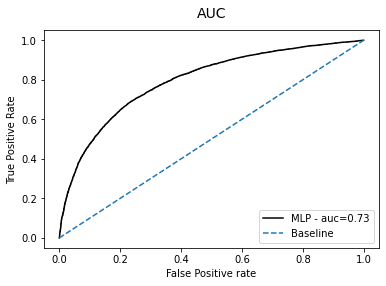

In [23]:
auc = round(roc_auc_score(y_test, y_pred), 2)
print(f'AUC: {auc}')

y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_prob)
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(fpr, tpr, label='MLP - auc='+str(auc), color='black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', label='Baseline')
plt.legend(loc=4)
plt.title('AUC', y=1.03, size=14)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive rate')
plt.grid(False)
plt.savefig('img/auc_acidentes_fatais.png')
plt.show()

Matriz de confusão

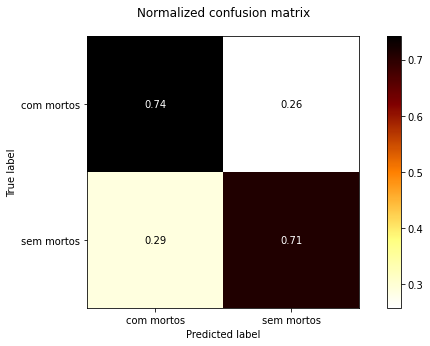

In [24]:
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=le.classes_.tolist(),
                                 cmap=plt.cm.afmhot_r,
                                 normalize='true'
                                 )
disp.ax_.set_title('Normalized confusion matrix', y=1.05)
plt.grid(False)
plt.savefig('img/matriz_confusao_acidentes_fatais.png')
plt.show()